<a href="https://colab.research.google.com/github/JPcarrasq/Data-Science-Marketing-Applications/blob/main/Optimizing_Product_Quantity_to_Maximize_Return_on_Investment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Optimizing Product Quantity to Maximize Return on Investment

In this project, we are going to analyze the production of a Colombian e-commerce platform to predict the number of products they will need to cover their sales and maximize the number of units to produce

##Import Libraries and Import Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
df= pd.read_csv("/content/orders_export_1 (1).csv")
df.head(7)

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Tax 5 Value,Phone,Receipt Number,Duties,Billing Province Name,Shipping Province Name,Payment ID,Payment Terms Name,Next Payment Due At,Payment References
0,#3000,diego.botia@udea.edu.co,paid,2024-01-07 10:40:40 -0500,unfulfilled,NaN,yes,COP,256600.0,14900.0,...,NaN,NaN,NaN,NaN,Antioquia,Antioquia,rTmnsWjgZXlmIuJKSGbILxbFC,NaN,NaN,rTmnsWjgZXlmIuJKSGbILxbFC
1,#3000,diego.botia@udea.edu.co,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#3000,diego.botia@udea.edu.co,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,#3000,diego.botia@udea.edu.co,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,#2999,mafeb2695@gmail.com,paid,2024-01-06 14:11:59 -0500,unfulfilled,NaN,yes,COP,119900.0,14900.0,...,NaN,NaN,NaN,NaN,Valle del Cauca,Valle del Cauca,rPobXgePbpJtAlGt1T4mcE8o6,NaN,NaN,rPobXgePbpJtAlGt1T4mcE8o6
5,#2998,villegas344@hotmail.com,paid,2024-01-03 13:01:29 -0500,unfulfilled,NaN,yes,COP,23900.0,14900.0,...,NaN,NaN,NaN,NaN,Antioquia,Antioquia,r6iRoS02DX4p2vAxxVAeAaNsd,NaN,NaN,r6iRoS02DX4p2vAxxVAeAaNsd
6,#2997,cabogota9626@gmail.com,paid,2024-01-02 18:41:56 -0500,unfulfilled,NaN,yes,COP,59900.0,14900.0,...,NaN,NaN,NaN,NaN,Cundinamarca,Cundinamarca,rSjpzzqBVtdPoNZ9h2f170mzf,NaN,NaN,rSjpzzqBVtdPoNZ9h2f170mzf


Transform Data into Columns

In [ ]:
# Reemplazar guiones por barras en la columna "Lineitem name"
df['Lineitem name'] = df['Lineitem name'].str.replace('-', '/')

# Divide la columna "Lineitem name" en varias columnas usando '/' como delimitador
df[['Nombre', 'Genero', 'Talla', 'Color']] = df['Lineitem name'].str.split('/', n=3, expand=True).fillna('')

# Mover las tallas que están en la columna "Color" usando como referencia la columna "Talla"
df.loc[df['Color'].str.upper().isin(['XS', 'S', 'M', 'L', 'XL', 'XXL']), 'Talla'] = df['Color']
df['Color'] = df['Color'].apply(lambda x: '' if x.upper() in ['XS', 'S', 'M', 'L', 'XL', 'XXL'] else x)

# Mover las tallas que están en la columna "Genero" usando como referencia la columna "Talla"
df.loc[df['Genero'].str.upper().isin(['XS', 'S', 'M', 'L', 'XL', 'XXL']), 'Talla'] = df['Genero']
df['Genero'] = df['Genero'].apply(lambda x: '' if x.upper() in ['XS', 'S', 'M', 'L', 'XL', 'XXL'] else x)

# Mover los colores que están en la columna "Genero" y "Talla" usando como referencia la columna "Color"
df.loc[df['Talla'].str.upper().isin(['AZUL', 'ROJO', 'VERDE', 'NEGRO', 'BLANCO']), 'Color'] = df['Talla']
df['Talla'] = df['Talla'].apply(lambda x: '' if x.upper() in ['AZUL', 'ROJO', 'VERDE', 'NEGRO', 'BLANCO'] else x)

df.loc[df['Talla'].str.upper() == 'NEGRA', 'Color'] = 'NEGRA'
df['Talla'] = df['Talla'].apply(lambda x: '' if x.upper() == 'NEGRA' else x)

# Mover los géneros que están en la columna "Talla" y "Color" usando como referencia la columna "Genero"
df.loc[df['Color'].str.lower().isin(['mujer', 'hombre', 'unisex']), 'Genero'] = df['Color'].str.lower()
df['Color'] = df['Color'].apply(lambda x: '' if x.lower() in ['mujer', 'hombre', 'unisex'] else x)

def move_genero_to_talla(row):
    if len(row['Genero']) <= 2:
        row['Talla'] = row['Genero']
        row['Genero'] = ''
    return row

# Función para mover 'Talla' a 'Color' si 'Talla' contiene la palabra 'negra'
def move_talla_to_color(row):
    if 'negra' in row['Talla'].lower():
        row['Color'] = row['Talla']
        row['Talla'] = ''
    return row

# Función para mover 'Color' a 'Genero' si 'Color' contiene la palabra 'hombre'
def move_color_to_genero(row):
    if 'hombre' in row['Color'].lower():
        row['Genero'] = row['Color']
        row['Color'] = ''
    return row

# Aplicar las funciones a cada fila del DataFrame
df = df.apply(move_genero_to_talla, axis=1)
df = df.apply(move_talla_to_color, axis=1)
df = df.apply(move_color_to_genero, axis=1)

def move_genero_to_talla_by_size(row):
    tallas = ['S', 'M', 'L', 'XL', 'XXL']
    if any(talla in row['Genero'].upper() for talla in tallas) and 'hombre' not in row['Genero'].lower() and 'mujer' not in row['Genero'].lower():
        row['Talla'] = row['Genero']
        row['Genero'] = ''
    return row

# Aplicar la función a cada fila del DataFrame
df = df.apply(move_genero_to_talla_by_size, axis=1)

##Descriptive Analysis

In [ ]:
df.describe()

,Subtotal,Shipping,Taxes,Total,Discount Amount,Lineitem quantity,Lineitem price,Lineitem compare at price,Note Attributes,Refunded Amount,...,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,Duties,Payment Terms Name,Next Payment Due At
count,2.000000e+03,2000.000000,2000.000000,2.000000e+03,2000.000000,3042.000000,3042.000000,1257.000000,0.0,2000.0,...,0.0,0.0,0.0,0.0,0.0,5.650000e+02,0.0,0.0,0.0,0.0
mean,1.159068e+05,7660.750000,15071.761890,1.236060e+05,3573.020500,1.058185,76019.170283,92636.903580,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,5.722125e+11,NaN,NaN,NaN,NaN
std,1.297853e+05,4902.111768,16934.504149,1.298956e+05,10059.535842,0.750469,47980.771313,49011.985335,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,2.171474e+10,NaN,NaN,NaN,NaN
min,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,20.000000,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,5.697620e+10,NaN,NaN,NaN,NaN
25%,5.990000e+04,5900.000000,7813.040000,6.881750e+04,0.000000,1.000000,24000.000000,63900.000000,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,5.730454e+11,NaN,NaN,NaN,NaN
50%,1.129000e+05,6900.000000,14726.090000,1.168000e+05,0.000000,1.000000,59900.000000,73900.000000,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,5.731336e+11,NaN,NaN,NaN,NaN
75%,1.399000e+05,11900.000000,18247.830000,1.441188e+05,0.000000,1.000000,126900.000000,111800.000000,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,5.731844e+11,NaN,NaN,NaN,NaN
max,4.446100e+06,70000.000000,579926.090000,4.464100e+06,100695.000000,26.000000,194900.000000,220700.000000,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,5.735081e+11,NaN,NaN,NaN,NaN


In [ ]:
confianza = 0.95
media_ventas = np.mean(df.Total)
std_ventas = np.std(df.Total, ddof=1)  # ddof=1 para usar la desviación estándar muestral

# Calcula el intervalo de confianza
intervalo_confianza = st.norm.interval(confianza, loc=media_ventas, scale=std_ventas/np.sqrt(len(df)))

print(f"Intervalo de confianza del {confianza * 100}% para la columna 'Total': {intervalo_confianza}")

Intervalo de confianza del 95.0% para la columna 'Total': (118989.99743264662, 128221.93756735338)


Top 25 best-selling products

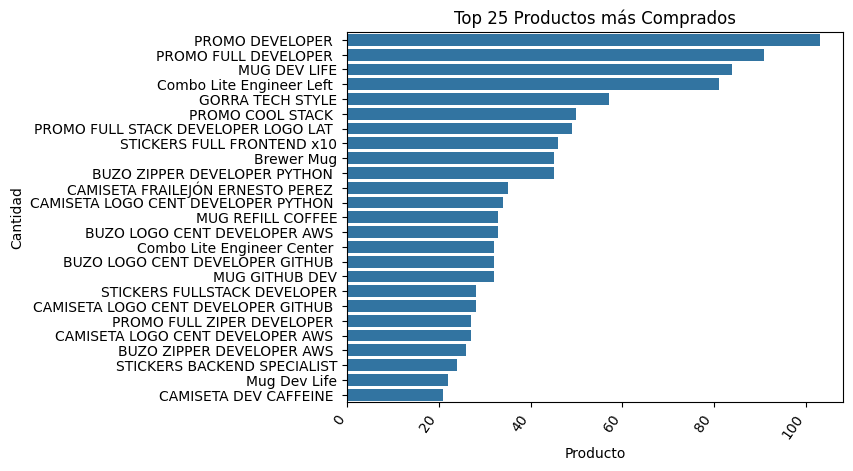

In [ ]:
import seaborn as sns


# Obtener los 10 productos más comprados
top_products = df["Nombre"].value_counts().nlargest(25)

# Crear un gráfico de barras para los 10 datos con el recuento más grande
ax = sns.barplot(x=top_products.values, y=top_products.index)

# Ajustar diseño
plt.xticks(rotation=45)
plt.xlabel('Producto')
plt.ylabel('Cantidad')
plt.title('Top 25 Productos más Comprados')

plt.xticks(rotation=55, ha='right')


# Mostrar el gráfico
plt.show()

Most requested sizes

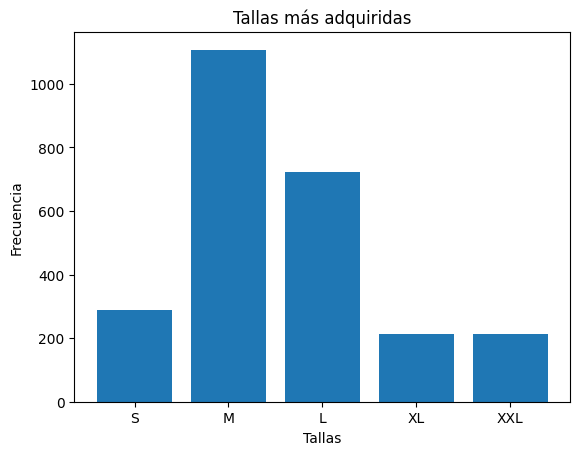

In [ ]:
Tallas_dict = {"S": 288, "M": 1107, "L": 723, "XL": 214, "XXL": 214}

tallas = list(Tallas_dict.keys())
frecuencias = list(Tallas_dict.values())

plt.bar(tallas, frecuencias)
plt.xlabel('Tallas')
plt.ylabel('Frecuencia')
plt.title('Tallas más adquiridas')
plt.show()

Talla: S, Probabilidad Predictiva: 0.1131
Talla: M, Probabilidad Predictiva: 0.4348
Talla: L, Probabilidad Predictiva: 0.2840
Talla: XL, Probabilidad Predictiva: 0.0841
Talla: XXL, Probabilidad Predictiva: 0.0841


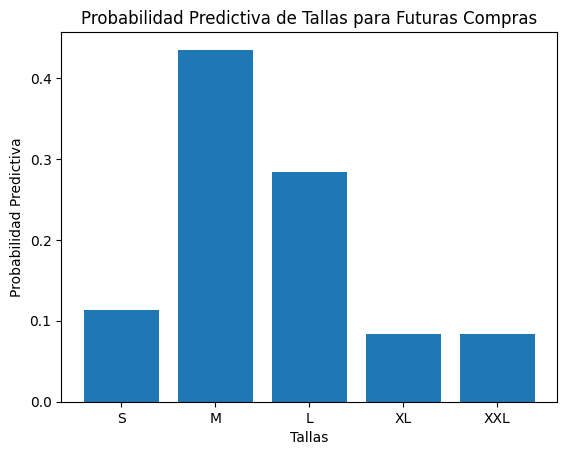

In [ ]:
Tallas_dict = {"S": 288, "M": 1107, "L": 723, "XL": 214, "XXL": 214}

# Convertir a array para facilitar los cálculos
frecuencias = np.array(list(Tallas_dict.values()))

# Calcular la probabilidad predictiva para cada talla
probabilidad_predictiva = frecuencias / sum(frecuencias)

# Imprimir resultados
for talla, prob in zip(Tallas_dict.keys(), probabilidad_predictiva):
    print(f"Talla: {talla}, Probabilidad Predictiva: {prob:.4f}")

# Visualizar las probabilidades predictivas
plt.bar(Tallas_dict.keys(), probabilidad_predictiva)
plt.xlabel('Tallas')
plt.ylabel('Probabilidad Predictiva')
plt.title('Probabilidad Predictiva de Tallas para Futuras Compras')
plt.show()

In [ ]:
df['Created at'] = pd.to_datetime(df['Created at'])

# Contar el número de compras por mes sin crear una nueva columna
conteo_por_mes = df['Created at'].dt.to_period('M').value_counts().sort_index()

# Imprimir el resultado
print(conteo_por_mes)

2021-02      1
2021-03     41
2021-04     34
2021-05     93
2021-06     87
2021-07     73
2021-08    134
2021-09     65
2021-10     97
2021-11     64
2021-12    150
2022-01     82
2022-02    130
2022-03    154
2022-04    130
2022-05    202
2022-06    181
2022-07    121
2022-08    115
2022-09    110
2022-10    126
2022-11     87
2022-12    117
2023-01     61
2023-02     78
2023-03     53
2023-04     34
2023-05     41
2023-06     43
2023-07     52
2023-08     37
2023-09     39
2023-10     26
2023-11     38
2023-12    139
2024-01      7
Freq: M, Name: Created at, dtype: int64


<ipython-input-11-68e6279db4c0>:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  conteo_por_mes = df['Created at'].dt.to_period('M').value_counts().sort_index()


<ipython-input-12-154731d02525>:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['Created at'].dt.to_period('M')


                    Created at    month  month_counts
0    2024-01-07 10:40:40-05:00  2024-01             7
1    2024-01-07 10:40:40-05:00  2024-01             7
2    2024-01-07 10:40:40-05:00  2024-01             7
3    2024-01-07 10:40:40-05:00  2024-01             7
4    2024-01-06 14:11:58-05:00  2024-01             7
...                        ...      ...           ...
3037 2021-03-03 22:43:46-05:00  2021-03            41
3038 2021-03-02 17:35:22-05:00  2021-03            41
3039 2021-03-02 14:14:37-05:00  2021-03            41
3040 2021-03-02 09:18:44-05:00  2021-03            41
3041 2021-02-21 22:00:20-05:00  2021-02             1

[3042 rows x 3 columns]


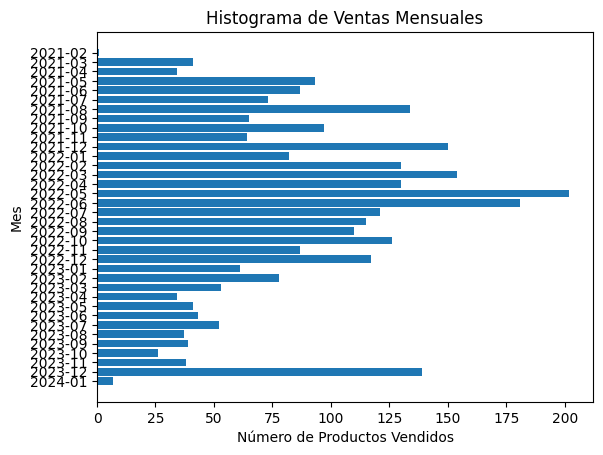

In [ ]:
# Convertir la columna 'Created at' a tipo de dato datetime
df['Created at'] = pd.to_datetime(df['Created at'])

# Crear una nueva columna 'month' que contiene el mes de cada fecha
df['month'] = df['Created at'].dt.to_period('M')

# Crear una nueva columna 'month_counts' con el número de ventas por mes
df['month_counts'] = df['month'].map(df['month'].value_counts())

# Imprimir el DataFrame con la nueva columna
print(df[['Created at', 'month', 'month_counts']])

# Construir un histograma de las ventas mensuales con ejes intercambiados
plt.barh(df['month'].astype(str), df['month_counts'])  # Usar plt.barh para barras horizontales
plt.ylabel('Mes')
plt.xlabel('Número de Productos Vendidos')  # Cambiar a 'Número de Productos Vendidos'
plt.title('Histograma de Ventas Mensuales')
plt.show()

##Linear Regression Model

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


   Created at  predicciones_month_counts
0  2024-01-31                  95.008926
1  2024-02-29                  94.151173
2  2024-03-31                  93.234266
3  2024-04-30                  92.346935
4  2024-05-31                  91.430027
5  2024-06-30                  90.542697
6  2024-07-31                  89.625789
7  2024-08-31                  88.708882
8  2024-09-30                  87.821551
9  2024-10-31                  86.904644
10 2024-11-30                  86.017313
11 2024-12-31                  85.100406


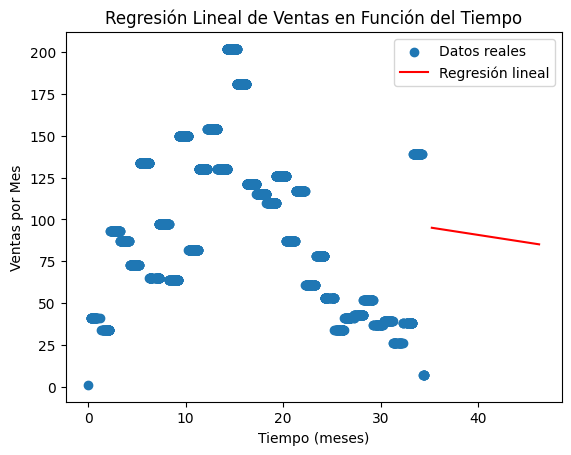

In [ ]:
# Convertir la columna 'Created at' a tipo de dato datetime y ajustar a un huso horario específico
df['Created at'] = pd.to_datetime(df['Created at']).dt.tz_localize(None)

# Crear una nueva columna 'time' que representa el tiempo en meses desde el inicio de tus datos
df['time'] = (df['Created at'] - df['Created at'].min()) / np.timedelta64(1, 'M')

# Crear el modelo de regresión lineal
model = LinearRegression()

# Ajustar el modelo con los datos existentes
model.fit(df[['time']], df['month_counts'])

# Generar datos para el año 2024
nuevos_meses_2024 = pd.date_range(start='2024-01-01', end='2024-12-31', freq='M')
nuevos_meses_2024_num = (nuevos_meses_2024 - df['Created at'].min()) / np.timedelta64(1, 'M')

# Realizar predicciones para el año 2024
predicciones_2024 = model.predict(nuevos_meses_2024_num.values.reshape(-1, 1))

# Crear un nuevo DataFrame con las predicciones
predicciones_df = pd.DataFrame({'Created at': nuevos_meses_2024, 'predicciones_month_counts': predicciones_2024})

# Imprimir las predicciones
print(predicciones_df)

# Visualizar la regresión lineal
plt.scatter(df['time'], df['month_counts'], label='Datos reales')
plt.plot(nuevos_meses_2024_num, predicciones_2024, color='red', label='Regresión lineal')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Ventas por Mes')
plt.title('Regresión Lineal de Ventas en Función del Tiempo')
plt.legend()
plt.show()

##Solving the Original Question

In [ ]:
# Datos de predicciones
data = {'Created at': ['2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31', '2024-11-30', '2024-12-31'],
        'predicciones_month_count': [95.008926, 94.151173, 93.234266, 92.346935, 91.430027, 90.542697, 89.625789, 88.708882, 87.821551, 86.904644, 86.017313, 85.100406]}

df_predicciones = pd.DataFrame(data)
tallas = {'S': 0.1131, 'M': 0.4348, 'L': 0.2840, 'XL': 0.0841, 'XXL': 0.0841}

# Iterar sobre las tallas e imprimir los resultados
for talla, valor_talla in tallas.items():
    resultado = valor_talla * df_predicciones['predicciones_month_count'][0]
    print(f"Para el mes de enero se deben realizar un máximo de {resultado:.2f} unidades Talla {talla}")

Para el mes de enero se deben realizar un máximo de 10.75 unidades Talla S
Para el mes de enero se deben realizar un máximo de 41.31 unidades Talla M
Para el mes de enero se deben realizar un máximo de 26.98 unidades Talla L
Para el mes de enero se deben realizar un máximo de 7.99 unidades Talla XL
Para el mes de enero se deben realizar un máximo de 7.99 unidades Talla XXL
